<a href="https://colab.research.google.com/github/GluteusStrength/Deep-Learning-projects/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install --user --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 43.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os

#  데이터 조작 및 시각화에 필요한 툴들 import
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 40
pd.options.display.max_columns = 10
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 모델링 알고리즘
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats


# Evaluation metrics
#regression용
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# classification용
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#텐서연산을 위한 백엔드
from keras import backend as K

In [ ]:
#결과값 고정을 위한 랜덤값 고정 =>실제 결과값 낼때는 풀기

import random as rn
import tensorflow as tf
import numpy as  np
import os

seed_num=0
np.random.seed(seed_num)
rn.seed(seed_num)
os.environ['PYTHONHASHSEED'] = '0'
tf.compat.v1.set_random_seed(
    seed_num
)


In [ ]:
tf.random.set_seed(
    seed_num
)

In [ ]:
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        print()
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('D', method='ffill')
    #전에껄로 채웠음
    raw_nfe = raw.copy()
    raw_nfe = raw_nfe.fillna(raw_nfe.mean())

    return raw_nfe
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('D', method='ffill')

    #과정2
    result = sm.tsa.seasonal_decompose(raw['배추_가격(원/kg)'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)



    Y_count_Week = raw[['배추_가격(원/kg)']].rolling(7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    Y_count_Month = raw[['배추_가격(원/kg)']].rolling(7*4).mean()
    Y_count_Month.fillna(method='ffill', inplace=True)
    Y_count_Month.fillna(method='bfill', inplace=True)
    Y_count_Month.columns = ['count_Month']
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)
    if 'count_Month' not in raw.columns:
        raw = pd.concat([raw, Y_count_Month], axis=1)

    Y_diff = raw[['배추_가격(원/kg)']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['배추_가격(원/kg)'].shift(1)
    raw['count_lag2'] = raw['배추_가격(원/kg)'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'],
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe

def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])

    return Score, Residual
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

def root_mean_squared_error(target, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - target)))


In [ ]:
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_felm = X_test.copy()
    for col in target:
        X_test_felm[col] = Y_test.shift(1).values
        X_test_felm[col].fillna(method='bfill', inplace=True)
        X_test_felm[col] = Y_test.shift(2).values
        X_test_felm[col].fillna(method='bfill', inplace=True)
    return X_test_felm

def feature_engineering_scaling(scaler, X_train, X_test):

    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train),
                               index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test),
                               index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling

def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = "/content/drive/MyDrive/nong/data/public_data/train.csv"
raw_all = pd.read_csv(data)
raw_all.rename(columns = {'date' : 'datetime'}, inplace = True)
raw_all=raw_all.drop(raw_all[(raw_all.iloc[:, 2:].sum(axis=1)==0)].index)

In [ ]:
raw_all.describe()

,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),...,애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
count,"1,486.00","1,486.00","1,486.00","1,486.00","1,486.00",...,"1,486.00","1,486.00","1,486.00","1,486.00","1,486.00"
mean,"1,298,026.75",696.37,"1,486,163.07",572.31,"1,931,989.01",...,"1,855.26","138,028.66","3,748.82","7,802.27","8,151.50"
std,"760,282.49",356.43,"516,969.89",240.19,"722,353.97",...,870.75,"261,086.59","1,841.43","26,073.11","7,981.42"
min,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00
25%,"895,263.10",450.00,"1,212,214.35",370.25,"1,528,831.12",...,"1,191.25","2,296.50","2,631.25",0.00,0.00
50%,"1,135,622.80",658.00,"1,444,523.50",510.00,"1,799,550.45",...,"1,734.50","6,769.30","3,579.50",487.00,"8,449.00"
75%,"1,449,343.77",833.00,"1,718,741.73",748.00,"2,257,841.17",...,"2,357.75","128,408.10","4,528.50","3,760.00","12,715.25"
max,"5,210,215.00","5,000.00","3,859,745.90","1,360.00","5,024,753.40",...,"6,778.00","1,490,337.00","25,000.00","382,263.40","40,000.00"


In [ ]:
raw_fe = feature_engineering(raw_all)

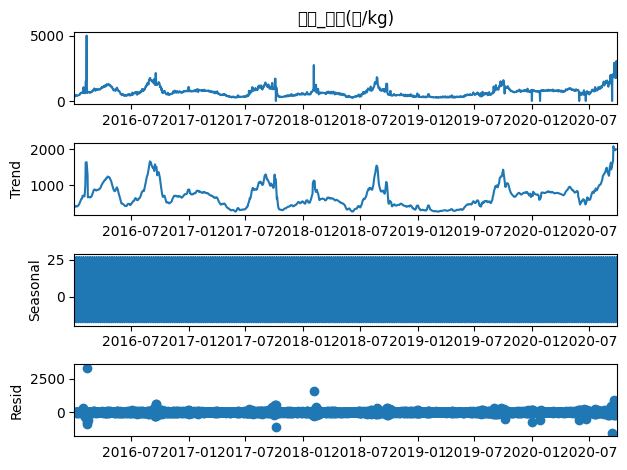

In [ ]:
# split data as trend + seasonal + residual
sm.tsa.seasonal_decompose(raw_fe['배추_가격(원/kg)'], model='additive').plot()
plt.show()

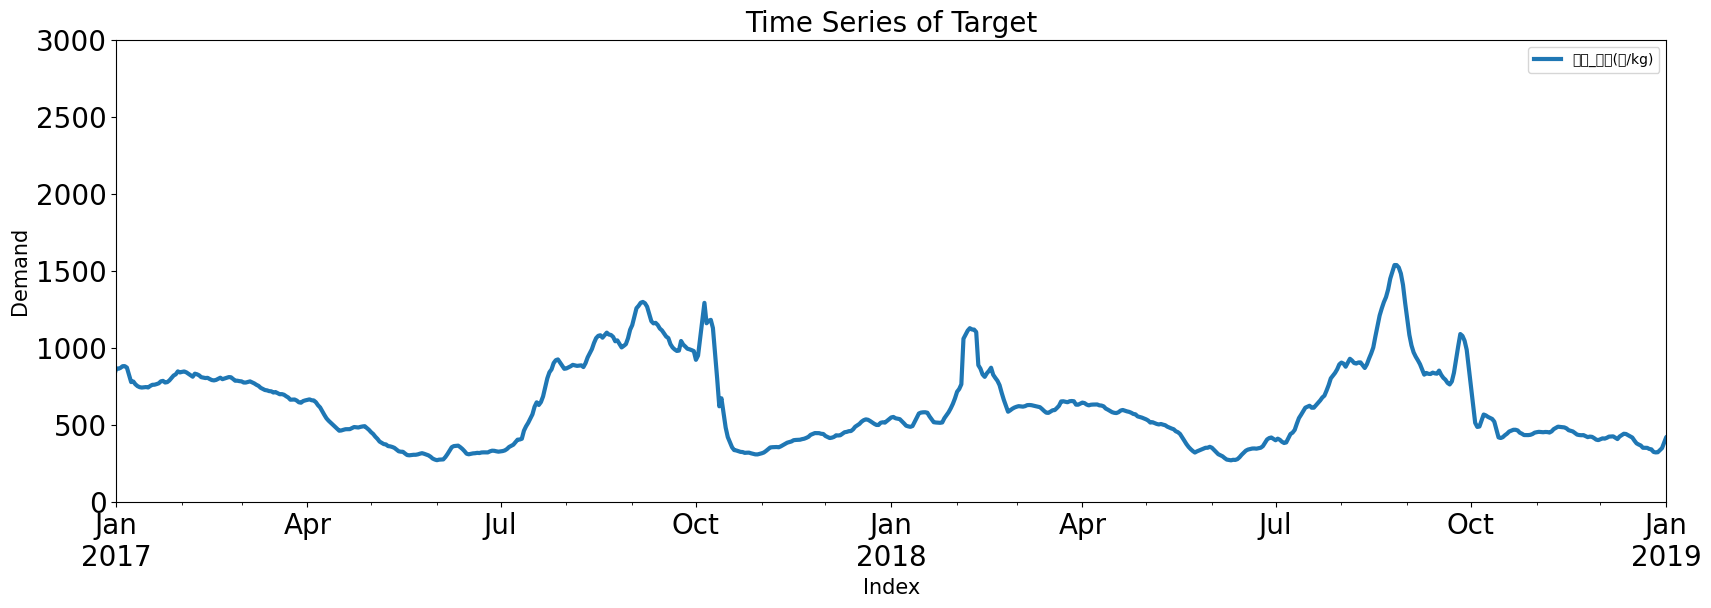

In [ ]:
# plot of moving average values using rolling function
raw_fe[['배추_가격(원/kg)']].rolling(7).mean().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                             xlim=('2017-01-01', '2019-01-01'), ylim=(0,3000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

In [ ]:
pd.concat([raw_fe[['배추_가격(원/kg)']],
           raw_fe[['배추_가격(원/kg)']].rolling(7).mean(),
           raw_fe[['배추_가격(원/kg)']].rolling(4*7).mean()], axis=1).plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                                                  xlim=('2017-01-01', '2019-01-01'), ylim=(0,5000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

In [ ]:
raw_fe[['배추_가격(원/kg)']].diff().plot(kind='line', figsize=(20,6), linewidth=3, fontsize=20,
                                 xlim=('2017-01-01', '2019-01-01'), ylim=(-2000,2000))
plt.title('Time Series of Target', fontsize=20)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Demand', fontsize=15)
plt.show()

In [ ]:
raw_fe.hist(bins=20, grid=True, figsize=(18,20))


In [ ]:
#feature engineering으로 바뀜-sm decomposion사용

y_col = ['배추_가격(원/kg)']
X_col = ["배추_거래량(kg)", 'count_lag1', 'count_lag2', "count_trend"]
X_train_fe, X_test_fe, y_train_fe, y_test_fe = datasplit_ts(raw_fe, y_col, X_col, '2018-01-01')

target=["price_lag1", "price_lag2"]
X_train_fe = feature_engineering_lag_modified(y_train_fe, X_train_fe, target)
X_test_fe = feature_engineering_lag_modified(y_test_fe, X_test_fe, target)

scaler_X_tr = preprocessing.RobustScaler()
scaler_y_tr = preprocessing.RobustScaler()
sequence = 7
batch_size = 50 #바꿔보기
epoch = 30 #30으로 바꿔보기
verbose = 1
dropout_ratio = 0.05


X_train_scaled = scaler_X_tr.fit_transform(X_train_fe)
y_train_scaled = scaler_y_tr.fit_transform(y_train_fe)
X_test_scaled = scaler_X_tr.transform(X_test_fe)
y_test_scaled = scaler_y_tr.transform(y_test_fe)

X_train, y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    y_train.append(np.ravel(y_train_scaled[index + sequence:index + sequence + 1]))
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    y_test.append(np.ravel(y_test_scaled[index + sequence:index + sequence + 1]))
X_test, y_test = np.array(X_test), np.array(y_test)


X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', y_test.shape)



# LSTM 씀

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio, seed=0))
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio, seed=0))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio, seed=0))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio, seed=0))
model.add(Dense(1))
model.compile(optimizer='adam', loss=root_mean_squared_error)
model.summary()
model_fit = model.fit(X_train, y_train,
                              batch_size=batch_size, epochs=epoch,
                              verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

    # evaluation!
result = model.evaluate(X_test, y_test_pred)


if scaler_y_tr != []:
    y_train = scaler_y_tr.inverse_transform(y_train)
    y_train_pred = scaler_y_tr.inverse_transform(y_train_pred)
    y_test = scaler_y_tr.inverse_transform(y_test)
    y_test_pred = scaler_y_tr.inverse_transform(y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(y_train), y_train_pred.flatten(),
                                                      pd.DataFrame(y_test), y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)
